# Important resources to implement
- [ ] To update the graph and route at the same time (Command): https://langchain-ai.github.io/langgraph/how-tos/command/
- [ ] To get React agent and structured output in two calls: https://langchain-ai.github.io/langgraph/how-tos/react-agent-structured-output/
- [ ] To develop react agent: https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/

In [1]:
import argparse
import datetime
import json
import random
import logging
import os
import re
import ast
import io
import sys
import duckdb

import numpy as np

from IPython.display import Image, display
from tqdm import tqdm
from pprint import pprint

from utils.utils import dynamic_import, load_config
from langchain_ollama import OllamaLLM, ChatOllama

from typing import Annotated, Union,Optional

from typing_extensions import TypedDict, Literal
from pydantic import BaseModel, field_validator, ValidationError, Field, model_validator

# from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.tools import BaseTool, tool

In [2]:
def setup_logger() -> logging.Logger:
    """Setup the logger configuration for consistency."""
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
        handlers=[logging.StreamHandler()],
    )
    return logging.getLogger(__name__)


logger = setup_logger()

## Get the data from the db

In [3]:
def get_text_from_db(conn, table_sections, pmcid):
    """
    Get the already recorded pmcids from db
    """
    cursor = conn.cursor()
    query = f"""
        SELECT abstract, SUBJECTS, METHODS
        FROM {table_sections} 
        WHERE pmcid = ?
    """
    cursor.execute(query, (pmcid,))
    row = cursor.fetchone()
    cursor.close()
    if row:
        abstract, subjects, method = row
        return abstract, subjects, method
    else:
        return None, None, None

In [79]:
# Load config
config_path = os.path.join("../config", "config.yaml")
config_all = load_config(config_path)

# DB connection
# # Name of the database
DB_FILE = config_all["api_europepmc_params"]["db_info_articles"]
table_status = config_all["db_params"]["table_status"]
table_sections = config_all["db_params"]["table_sections"]
table_metadata = config_all["db_params"]["table_metadata"]
table_inference = config_all["db_params"]["table_inference"]
# # Using duckdb to access the sqlite file for compatibility on marenostrum
conn = duckdb.connect(f"../{DB_FILE}")

# List of PMCID for testing
list_pmcids = [
    'PMC10167034', 'PMC10191296', 'PMC10262854', 'PMC10390885', 'PMC10451945',
    'PMC1368980',  'PMC2383879',  'PMC2693442',  'PMC3016279',  'PMC3041764',
    'PMC3145824',  'PMC3174812',  'PMC3212907',  'PMC3219398',  'PMC3308973',
    'PMC3446531',  'PMC3534646',  'PMC3619104',  'PMC3804564',  'PMC3909226',
    'PMC4006427',  'PMC4023701',  'PMC4029655',  'PMC4065281',  'PMC4152203',
    'PMC4221596',  'PMC4251014',  'PMC4344476',  'PMC4393161',  'PMC4492682',
    'PMC4596022',  'PMC4640153',  'PMC4928460',  'PMC5040013',  'PMC5053679',
    'PMC5076567',  'PMC5087213',  'PMC5137654',  'PMC5149569',  'PMC5253404',
    'PMC5308745',  'PMC5425199',  'PMC5441889',  'PMC5601641',  'PMC5645380',
    'PMC5717332',  'PMC5784259',  'PMC5839230',  'PMC5961641',  'PMC6060212',
    'PMC6076250',  'PMC6145291',  'PMC6160275',  'PMC6248768',  'PMC6286024',
    'PMC6730009',  'PMC6760014',  'PMC6775309',  'PMC6853912',  'PMC6858051',
    'PMC6955584',  'PMC7007877',  'PMC7011053',  'PMC7436656',  'PMC7449478',
    'PMC7537889',  'PMC7550220',  'PMC7657407',  'PMC7661891',  'PMC7722655',
    'PMC7722817',  'PMC7734296',  'PMC7882770',  'PMC7903471',  'PMC7906844',
    'PMC7956942',  'PMC8155599',  'PMC8288503',  'PMC8382172',  'PMC8456091',
    'PMC8723790',  'PMC8752710',  'PMC8771850',  'PMC8976245',  'PMC9028212',
    'PMC9081438',  'PMC9138181',  'PMC9305770',  'PMC9333080',  'PMC9381901',
    'PMC9413660',  'PMC9422814',  'PMC9529122',  'PMC9537611',  'PMC9601430',
    'PMC9616492',  'PMC9636513',  'PMC9683380',  'PMC9697589'
]
pmcid_method = list()
for pmcid in list_pmcids:#[0:10]:
    
    abstract, subjects, method = get_text_from_db(conn, table_sections, pmcid)
    pmcid_method.append({'pmcid': pmcid, 'abstract': abstract, 'method': method, 'subjects': subjects})

In [5]:
# Tools
@tool
def extract_section_tool(document: dict, section: str) -> str:
    """
    Extracts a specific section (e.g., 'Abstract', 'Method', 'Result') from a single document dictionary.
    If the section does not exist, returns an empty string.
    """
    return document.get(section, "No content available.")

In [33]:
## Instanciate LLMs
model_name = "llama3.2:latest"
#model_name = "qwen2.5:14b"
#model_name = "llama3.2:3b-instruct-fp16"
#model_name = "qwen2.5:14b-instruct-q5_K_S"
model_name = 'phi4'
llm = ChatOllama(model=model_name)
llm.temperature = 0

In [47]:
# States
class PrivateState(BaseModel):
    pass
    
class DecisionState(BaseModel):
    article: dict = {}
    answer_context: dict = Field(default={}, description="Context of the decision process from the agent")
    human_subjects: bool = Field(default=False, description="Does the article contain information about human subjects")
    sex_or_sample_data: bool = Field(default=False, description="Does the article contains information about the sex of the subjects")
    multi_sample: bool = Field(default=False, description="Does the research involves several samples")
    #one_subject: bool = Field(default=False, description="Does the samples provides from the same subject")   
    multi_cohorts: bool = Field(default=False, description="Are there several cohorts")
    cohorts_overlap: bool = Field(default=False, description="Are some subjects present in more than one cohort")
    dropouts_before: bool = Field(default=False, description="Are there participants who drop the studies before the research started")
    dropouts_during: bool = Field(default=False, description="Are there participants who drop the studies during the research")
    droupouts_after: bool = Field(default=False, description="Are there participants who drop the studies after the research")
    info_text: bool = Field(default=False, description="Is the information contained in the text")
    info_table: bool = Field(default=False, description="Is the information contained in table")


class ResultResponse(BaseModel):
    n_male: float = Field(default=np.nan, description="The total number of unique male reported in the paper")
    n_female: float = Field(default=np.nan, description="The total number of unique female reported in the paper")
    n_sample: float = Field(default=np.nan, description="The total number of unique participants reported in the paper")


class FinalResponse(DecisionState, ResultResponse):
    pass

In [48]:
# Pydantic parsers
from pydantic import BaseModel, Field, model_validator
import json
import ast

class BooleanParser(BaseModel):
    answer: bool = Field(description="Must be either 'True' or 'False'")
    
    @model_validator(mode="before")
    @classmethod
    def preprocess_input(cls, values: dict) -> dict:
        raw_answer = values.get("answer")
        
        if isinstance(raw_answer, str):
            # Clean and convert string if necessary
            raw_answer = cls._clean_and_convert_string(raw_answer)
        
        # Handle case where raw_answer is a dictionary with an 'answer' field
        if isinstance(raw_answer, dict) and "answer" in raw_answer:
            raw_answer = raw_answer["answer"]
        
        # If it's still a string, check for valid "true"/"false" values
        if isinstance(raw_answer, str):
            stripped_answer = raw_answer.strip().lower()
            if stripped_answer in ("true", "false"):
                raw_answer = stripped_answer == "true"
        
        # If the answer is neither boolean nor string, raise an error
        if not isinstance(raw_answer, bool):
            raise ValueError(f"Answer must be 'True' or 'False', got: {raw_answer}")
        
        values["answer"] = raw_answer
        return values

    @staticmethod
    def _clean_and_convert_string(raw_answer: str) -> any:
        raw_answer = raw_answer.strip("`").strip()
        
        if raw_answer.startswith('```json') and raw_answer.endswith('```'):
            # Remove the ```json``` markers
            raw_answer = raw_answer[7:-3].strip()

        # Replace 'True'/'False' to lowercase for uniformity
        raw_answer = raw_answer.replace("True", "true").replace("False", "false")
        
        try:
            # Try to parse as JSON
            raw_answer = json.loads(raw_answer)
        except json.JSONDecodeError:
            try:
                # Try to evaluate as a Python literal
                raw_answer = ast.literal_eval(raw_answer)
            except (ValueError, SyntaxError):
                print(f"Failed to parse raw_answer: {raw_answer}")
                pass
        
        return raw_answer
    
    @model_validator(mode="after")
    @classmethod
    def validate_answer(cls, model: "BooleanParser") -> "BooleanParser":
        if not isinstance(model.answer, bool):
            raise ValueError(f"Answer must be a boolean (True or False), got: {model.answer}")
        return model
    
    
class ContextParser(BooleanParser):
    context: str = Field(default='', description="Relevant sentences or data supporting the decision")

    @model_validator(mode="before")
    @classmethod
    def preprocess_input(cls, values: dict) -> dict:
        # First, handle BooleanParser preprocessing
        values = super().preprocess_input(values)

        # Additional preprocessing for context
        raw_context = values.get("context", "")
        if isinstance(raw_context, str):
            values["context"] = raw_context.strip()

        return values

In [49]:
# Nodes
def human_subject_decision(state: DecisionState) -> dict:
    """
    Determines if the article discusses human subjects by querying different sections of a single document.
    """
    print('Inside the human_subject_decision node')
    
    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to determine if the article consider human subjects for a study. 
    Analyze the following section: {section_header} of the document:
    {section_content}
    Answer as follows:
    - 'True': The document mentions human subjects.
    - 'False': The document does not mention human subjects, or there is not enough information to take an informed decision

    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    Fully respect the format_instruction and don't answer anything more than what it is asked
    """
  
    parser = PydanticOutputParser(pydantic_object=BooleanParser)
    
    for section in state.article:
        section_content = state.article[section]

        if section.lower() == 'pmcid'  or section_content is None:
            continue  # Skip if the section is not available
        # Call the tool to extract the section
        print(f"Section: {section} - Nbr of word {len(section_content)}")

        chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

        prompt_messages = chat_prompt.format_messages(section_header=section, section_content=section_content, format_instructions=parser.get_format_instructions())
        response = llm.invoke(prompt_messages)
#           print(response)

        try:
            # print(f"The full answer: {response}")
            print(f"The response content: {response.content}")
            parsed_response = parser.invoke(response.content)
            #print(f"Parsed response: {parsed_response.answer}")

            if parsed_response.answer == True:  # If 'True' is found, return immediately
                return {"human_subjects": parsed_response.answer}
        except ValueError as e:
            print(f"Error in human node: {response}")
            raise ValueError("Validation failed for model: " + str(e))

    return {"human_subjects": False}

In [70]:
def contain_sex_or_sample(state: DecisionState):
    """
    Determines if the article contains information about sex. 
    """
    print('Inside the contain_sex_or_sample node')
    
    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    """
    user_message = """
    The article includes experiment involving human subjects. 
    Your task is to determine the presence of information about sex or gender in the section. 
    
    Here, 4 non-exhaustive examples of what it may look like:
    #######

    Example 1: Twenty-seven subjects (age range 19–58, ten female) diagnosed with an ASD (see Table 1) participated in this study. 
    ASD diagnosis was determined using the Autism Diagnostic Observation Schedule (ADOS), 
    Module 4. Additionally, fifteen typical adults recruited from the local community served as behavioral controls (age range 19–59) and only participated in the face discrimination experiment described in Section 2.3.

    Example 2: The strategy was to select contrasting groups including the 200 women and men (100 each) with the highest EE scores, 200 with medium EE and 200 with the lowest EE scores. 
    After plotting the EE scores for women and men separately, the cutoff was set around the highest quartile, the median and around the lowest quartile. 
    The selection procedures yielded a sample of 720 individuals. Some of them enrolled in a parallel study were excluded. 
    As a result, the final sample included 687 individuals consisting of 143 women and 127 men with low EE scores, 118 women and 110 men with medium EE scores and 119 women and 103 men with high EE scores.

    Example 3: Table 1Subject characteristics at baseline1VLCARBVLFHUFmales/females4/205/173/18BMI kg/m232.5 \u00b1 3.132.6 \u00b1 4.033.4 \u00b1 3.6AGE y48.4 \u00b1 8.050.7 \u00b1 10.346.1 \u00b1 9.5Total Cholesterol mmol/L5.8 \u00b1 1.05.6 \u00b1 1.16.0 \u00b1 1.1LDL-C mmol/L3.8 \u00b1 0.83.6 \u00b1 1.14.0 \u00b1 1.1HDL-C mmol/L1.2 \u00b1 0.21.3 \u00b1 0.31.2 \u00b1 0.2Triacylglycerols mmol/L1.8 \u00b1 0.91.5 \u00b1 0.61.6 \u00b1 0.51 Data are Mean \u00b1 SD. VLCARB = very low carbohydrate diet (n = 24) VLF = very low fat diet (n = 22) HUF = high unsaturated fat (n = 21)

    Example 4:Fifteen healthy human volunteers took part in the study. They were screened for normal stereoacuity before being invited to participate. 
    Two were later excluded because of poor binocular fusion during scanning. Therefore, data from 13 participants (10 female; mean age 27 yr) were included in the analysis.
    ########
    
    Do that analyse for the following section {section_header} of the document:
    
    {section_content}

    Answer as follows:
    - 'True': The document contains information to know if some participants are males or females or if the information about the gender is given. Even if only one gender or sex can be inferred, answer True
    - 'False': The document does not contain information about the sex or the gender of the participants.
    Additionally, if the answer is 'True', include the relevant sentences or table excerpts from the section that support your decision in the 'context' field
    If the document is empty, just answer False, I will provide another section to try again.
    
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    Fully respect the format_instruction and don't answer anything more than what it is asked
    """
  
    parser = PydanticOutputParser(pydantic_object=ContextParser)

    for section in state.article:
        section_content = state.article[section]

        if section.lower() == 'pmcid'  or section_content is None:
            continue  # Skip if the section is not available
        # Call the tool to extract the section
        print(f"Section: {section} - Nbr of word {len(section_content)}")

        chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

        prompt_messages = chat_prompt.format_messages(section_header=section, section_content=section_content, format_instructions=parser.get_format_instructions())
        response = llm.invoke(prompt_messages)
#           print(response)

        try:
            # print(f"The full answer: {response}")
            
            print(f"The response content: {response.content}")
            parsed_response = parser.invoke(response.content)
            #print(f"Parsed response: {parsed_response.answer}")

            if parsed_response.answer == True:  # If 'True' is found, return immediately
                return {"sex_or_sample_data": parsed_response.answer}
        except ValueError as e:
            print(f"Error in human node: {response}")
            raise ValueError("Validation failed for model: " + str(e))

    return {"sex_or_sample_data": False}

In [78]:
def multi_samples(state: DecisionState) -> str:
    """
    Determines if the article mentions sample from multi individuals, or if there are several participants
    """
    print('Inside the multi_samples node')

    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to determine the presence of information about sex or gender in the following study.
    Analyze the following section: {section_header} of the document:
    {section_content}
    Answer as follows:
    - 'True': If the experience report to have more than one human subject or participant
    - 'False':  If it is not involving several humans or subjects and or several lines of tissues, cells, etc or there is not enough information to take an informed decision
    Additionally, if the answer is 'True', include the relevant sentences or table excerpts from the section that support your decision in the 'context' field.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    Fully respect the format_instruction and don't answer anything more than what it is asked
   """
    parser = PydanticOutputParser(pydantic_object=ContextParser)

    for section in state.article:
        section_content = state.article[section]

        if section.lower() == 'pmcid'  or section_content is None:
            continue  # Skip if the section is not available
        # Call the tool to extract the section
        print(f"Section: {section} - Nbr of word {len(section_content)}")

        chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

        prompt_messages = chat_prompt.format_messages(section_header=section, section_content=section_content, format_instructions=parser.get_format_instructions())
        response = llm.invoke(prompt_messages)
#           print(response)

        try:
            # print(f"The full answer: {response}")
            
            print(f"The response content: {response.content}")
            parsed_response = parser.invoke(response.content)
            #print(f"Parsed response: {parsed_response.answer}")

            if parsed_response.answer == True:  # If 'True' is found, return immediately
                return {"multi_sample": parsed_response.answer}
        except ValueError as e:
            print(f"Error in human node: {response}")
            raise ValueError("Validation failed for model: " + str(e))

    return {"multi_sample": False}

In [71]:
def multi_cohort(state: DecisionState) -> str:
    """
    Determines if there are several cohorts or studies in the same article.
    """
    print('Inside the multi_cohort node')

    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to understand if the reported experience are about several human subjects or about only one participant. 
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    Additionally, if the answer is 'True', include the relevant sentences or table excerpts from the section that support your decision in the 'context' field.

    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

    parser = PydanticOutputParser(pydantic_object=ContextParser)
    
    for section in state.article:

        # Call the tool to extract the section
        section_content = state.article[section]
        if section_content == "No content available.":
            continue  # Skip if the section is not available
        
    
        chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

        prompt_messages = chat_prompt.format_messages(section_header=section, section_content=section_content, format_instructions=parser.get_format_instructions())
        response = llm.invoke(prompt_messages)
        try:
            parsed_response = parser.invoke(response.content.strip())
            #print(f"Parsed response: {parsed_response.answer}")
            if parsed_response.answer == True:  # If 'True' is found, return immediately
                context = state.answer_context
                context['multi_cohort'] = {section: parsed_response.context }

                return {"multi_cohort": parsed_response.answer,
                        "answer_context": context}
        except ValueError as e:
            raise ValueError("Validation failed for model: " + str(e))

    return {"multi_cohort": parsed_response.answer}


In [72]:
def participants_dropout(state: DecisionState) -> str:
    """
    Determines if there are several cohorts or studies in the same article.
    """
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains one study or one experience about human subjects humans subject:\n\n{article}
    In study it can happens that some participants are selected before the survey but eventually are removed for various reasons. 
    It can be also the case that participants are dropping out during the study or even after the study is done. 
    Your task is to analyse the text provided which details the method section. In there you need to figure out if there is such case of dropout.
    If partipants (or subjects) are removed before the ss
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

    parser = PydanticOutputParser(pydantic_object=BooleanParser)
    
    chat_prompt = ChatPromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=state.article, format_instructions=parser.get_format_instructions())

    response = llm.invoke(prompt_messages)
    # print(f"Straight response: {response}")

    try:
        # print("Raw response content:", response.content.strip())
        parsed_response = parser.invoke(response.content.strip())
        # print("Parsed response:", parsed_response)  # Debugging print
    except ValueError as e:
        raise ValueError("Validation failed for model: " + str(e))

    return {"multi_cohort": parsed_response.answer}


def participant_dropout_tools():
    return True

In [73]:
def extract_information(state: DecisionState) -> dict:
    """
    Extracts numerical data (e.g., number of males, females, total participants).
    """
    if state.multi_cohort == True:
        adding_message = 'There are several cohort in the article'
    else:
        adding_message = ''
    system_message = "You are a helpful assistant that needs to extract information from a scientific article from pubmed and follow the instruction given by the user"
    user_message = """Here is a scientific article. It contains experience and or survey about humans subject :\n\n{article}
    Your task is to understand if the reported experience are about several human subjects or about only one participant. 
    \t If the experience report to have more than one human subject or participant, answer 'True'.
    \t If it is not involving several humans or subjects and or several lines of tissues, cells, etc, answer 'False'.
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}"""

In [74]:
def calculate_numbers(state: DecisionState) -> dict:
    """
    Extracts numerical data (e.g., number of males, females, total participants).
    """
    result_response = ResultResponse(
        n_male=50, 
        n_female=60, 
        n_sample=110
    )
    return {
        "n_male": result_response.n_male,
        "n_female": result_response.n_female,
        "n_sample": result_response.n_sample,
    }

In [75]:
def human_decision_router(state: DecisionState) -> str:
    print(f"In human_decision_router: {state.human_subjects}")
    if state.human_subjects is True:
        return "contain_sex_or_sample"
    elif state.human_subjects is False:
        return END
    else:
        raise

def contain_sex_router(state: DecisionState) -> str:
    print(f"In contain_sex_router: {state.sex_or_sample_data}")
    if state.sex_or_sample_data == True:
        return "multi_samples"
    elif state.sex_or_sample_data == False:
        return END

def multi_sample_router(state: DecisionState) -> str:
    print(f"In multi_sample_router: {state.multi_sample}")
    if state.multi_sample == "True":
        return "multi_cohort"
    elif state.multi_sample == "False":
        return END

def multi_cohort_router(state: DecisionState) -> str:
    print(f"In multi_sample_router: {state.multi_sample}")
    if state.multi_cohort == "True":
        return END
    elif state.multi_cohort == "False":
        return "participants_dropout"

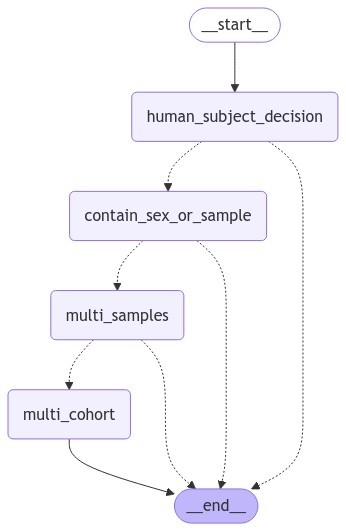

In [76]:
graph = StateGraph(DecisionState, output=FinalResponse)

graph.add_node("human_subject_decision", human_subject_decision)
graph.add_node("contain_sex_or_sample", contain_sex_or_sample)
graph.add_node("multi_samples", multi_samples)
graph.add_node("multi_cohort", multi_cohort)
#graph.add_node("participants_dropout", participants_dropout)


#graph.add_node("calculate_numbers", calculate_numbers)

graph.add_edge(START, "human_subject_decision")
graph.add_conditional_edges("human_subject_decision", human_decision_router,  path_map=["contain_sex_or_sample", END])
graph.add_conditional_edges("contain_sex_or_sample", contain_sex_router, path_map=["multi_samples", END])
graph.add_conditional_edges("multi_samples", multi_sample_router, path_map=["multi_cohort", END])
#graph.add_conditional_edges("multi_cohort", multi_cohort_router, path_map=["participants_dropout", END])

#graph.add_edge("participants_dropout", "calculate_numbers")
#graph.add_edge("calculate_numbers", END)
graph.add_edge('multi_cohort', END)
graph = graph.compile()
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [77]:
for article in pmcid_method:
    initial_state = DecisionState(article=article)  # Call the initial_state like that otherwise DecisionState is not populated with default values
    result = graph.invoke(initial_state)  
    del result['article']
    print(f"Final answer: {result}")


Inside the human_subject_decision node
Section: method - Nbr of word 8763


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


The response content: ```json
{
  "answer": true
}
```
In human_decision_router: True
Inside the contain_sex_or_sample node
Section: method - Nbr of word 8763


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


The response content: ```json
{
  "answer": false,
  "context": ""
}
```
In contain_sex_router: False
Final answer: {'answer_context': {}, 'human_subjects': True, 'sex_or_sample_data': False, 'multi_sample': False, 'multi_cohorts': False, 'cohorts_overlap': False, 'dropouts_before': False, 'dropouts_during': False, 'droupouts_after': False, 'info_text': False, 'info_table': False}
Inside the human_subject_decision node
Section: method - Nbr of word 14076


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


The response content: ```json
{
  "answer": true
}
``` 

The document mentions human subjects as it discusses a study involving Medicare beneficiaries, which are individuals. The study includes data on incident neurodegenerative disease among these individuals, indicating that the research involves human participants. Therefore, the answer is 'True'.
In human_decision_router: True
Inside the contain_sex_or_sample node
Section: method - Nbr of word 14076


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


The response content: ```json
{
  "answer": true,
  "context": "We also censored individuals if and when they developed atypical parkinsonism, developed dementia with Lewy bodies, or enrolled in Part C coverage. We used age as the time scale to account for age and then included all other covariates as independent variables in the model."
}
```
In contain_sex_router: True
Inside the multi_samples node


INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


In multi_sample_router: True


KeyError: None

### 

In [ ]:
# Example inputs to validate
weird_string_test = '```json\n{\n  "answer": True\n}\n```'

inputs = [
    {"answer": "False"},                       # String "False"
    {"answer": "True"},                        # String "True"
    {"answer": "true"},                        # Case-insensitive "true"
    {"answer": "false"},                       # Case-insensitive "false"
    {"answer": '{"answer": "True"}'},          # JSON with nested "True" as string
    {"answer": '{"answer": true}'},            # JSON with boolean true
    {"answer": "True   "},                     # String with extra whitespace
    {"answer": "False   "},                    # String with extra whitespace
    {"answer": "Not a boolean"},               # Invalid string
    {"answer": '{"answer": "Not a boolean"}'}, # Nested invalid value
    {"answer": '{"answer": false}'},           # Nested valid boolean false
    {"answer": True},                          # Python-style True
    {"answer": False},                         # Python-style False
    {"answer": None},                          # None input
    {"answer": weird_string_test},             # Weird string with JSON-like content
]

# Test each input
for i, input_data in enumerate(inputs):
    try:
        print(f"Testing input {i + 1}: {input_data}")
        result = BooleanParser(**input_data)
        print(f"Test case {i+1}: {input_data} -> Parsed: {result}")
    except ValueError as e:
        print(f"Test case {i+1}: {input_data} -> Error: {e}")
    except Exception as e:
        print(f"Test case {i+1}: {input_data} -> Unexpected Error: {e}")